# Pest Disease Image Classification

In [1]:
# Import all the dependencies

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers


Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [2]:
# set the constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import Pest image data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4074 files belonging to 15 classes.


In [4]:
# Store class names into variable
class_names = dataset.class_names
class_names 

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
# Each batch of the image is 32 images, we have 128 batches
len(dataset)

128

In [6]:
# Printing shape of batches
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[14 12 12 12 12 12 14 12 14 14 12 12 14 12 12 12 13 14 12 12 14 12 14 12
 12 12 12 12 12 12 12 14]


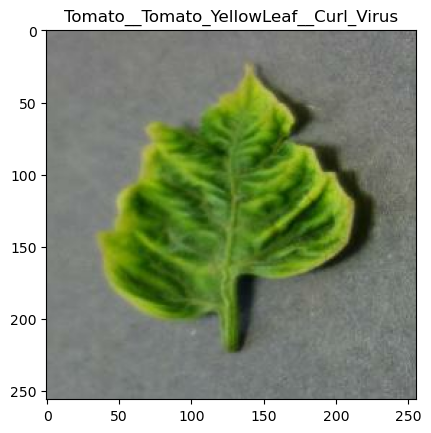

In [7]:
# Print first image (each time image display would be different due to shuffle randomness)
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    # Print image classname
    plt.title(class_names[label_batch[0]])

### Visualize the input data

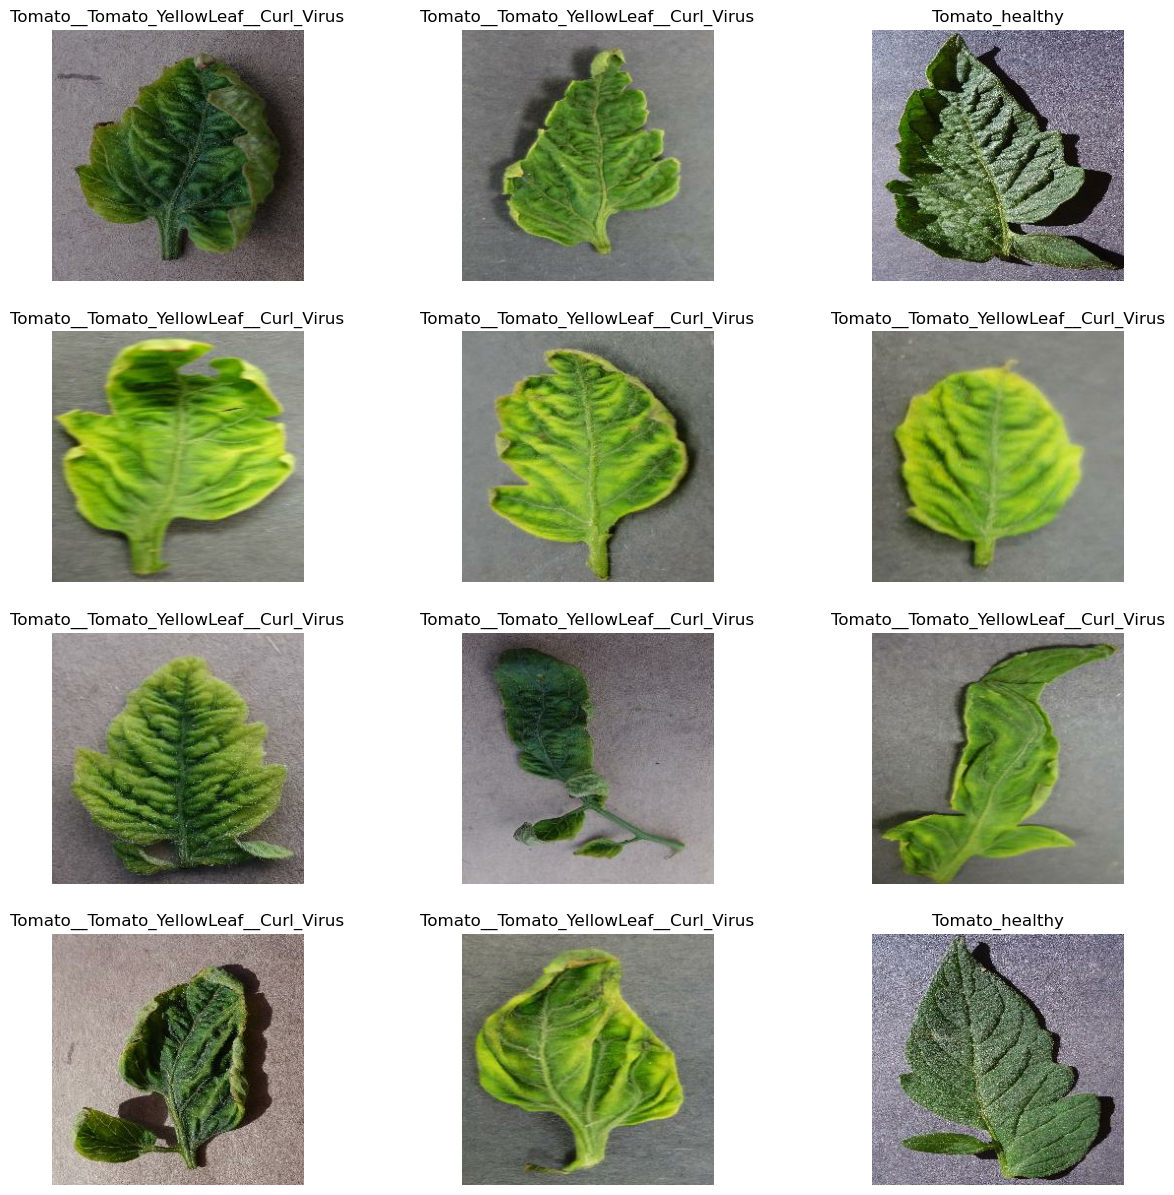

In [8]:
plt.figure(figsize = (15, 15))
# Print first 12 images
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #convert float32 to uint8 for RGB image
        # Print image classname
        plt.title(class_names[label_batch[i]])
        
        # Turn off axis
        plt.axis('off')
plt.savefig('input_data_visualize.png')

#### Split the dataset 
The Standard test train split (80% train, 20% test)
- 80% ==> training
- 20% ==> 10% validation, 10% test

In [9]:
# Split train dataset
train_size = 0.8
len(dataset)*train_size

102.4

In [10]:
train = dataset.take(102)
len(train)

102

In [11]:
# Store the remaining 20% of the data as test
test_ds = dataset.skip(102)
len(test_ds)

26

In [12]:
val_size=0.1
len(dataset)*val_size

12.8

In [13]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [14]:
test_ds = test_ds.skip(13)
len(test_ds)

13

 Make a function to do the above Test Train Split for us

In [15]:
# Define function to split data
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
# Calling function to split data
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
print(f'train size {len(train_ds)}')
print(f'val size {len(val_ds)}')
print(f'test size {len(test_ds)}')

train size 102
val size 12
test size 14


Cache, Shuffle, and Prefetch the Dataset to improve performance

In [18]:
# Cache data and optimize speed
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Image Preprocessing and Data Augmentation

In [19]:
# Resize and rescale image

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Build the CNN Model

In [21]:
# Define neural network architecture
n_classes = len(class_names)
# input shape = image size, channel
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# Set layers of model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape, padding='same'), # Convolution + reLu
    layers.MaxPooling2D((2,2)), # Pooling
    # Repeat to increase the number of filters
    layers.Conv2D(64, (3,3), activation = 'relu', padding='same'), # add zero padding to make output same size as input
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), # Flatten into a feature vector
    layers.Dense(64, activation = 'relu'),
    # softmax normalized probability of classes
    layers.Dense(n_classes,activation = 'softmax'), # FCN output layer of shape (batch_size, n_classes)
    
])
model.build(input_shape = input_shape)

### Visualize the Model Architecture

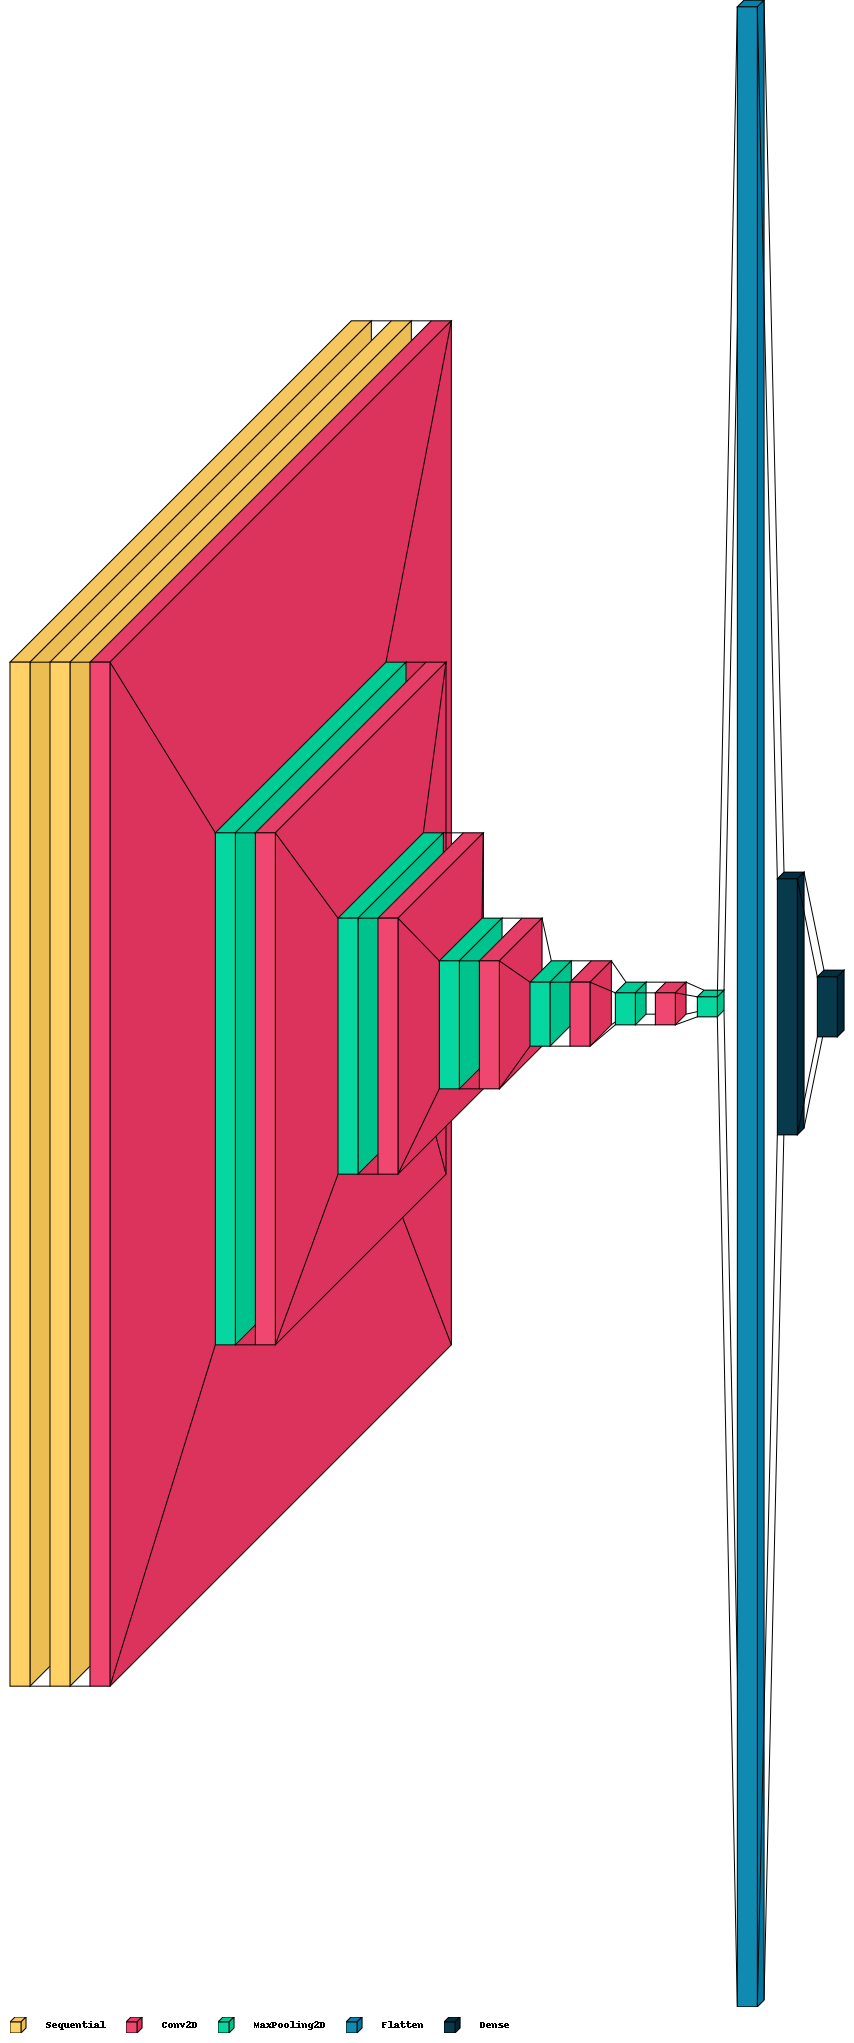

In [22]:
import visualkeras

visualkeras.layered_view(model, legend=True, spacing=20, one_dim_orientation='y', to_file='model_architecture.png') # write the image to file

from IPython.display import Image
Image(filename='model_architecture.png') 

In [23]:
# summary of model to see the number of parameters and output shape
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 256, 256, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 128, 128, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 128, 128, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 64, 64, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 64, 64, 64)         

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [24]:
# Compile using optimizer
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 50,
)

Epoch 1/50
102/102 [==============================] - 11s 56ms/step - loss: 0.8622 - accuracy: 0.7008 - val_loss: 0.4686 - val_accuracy: 0.8255
Epoch 2/50
102/102 [==============================] - 3s 34ms/step - loss: 0.3925 - accuracy: 0.8621 - val_loss: 0.3227 - val_accuracy: 0.8698
Epoch 3/50
102/102 [==============================] - 3s 33ms/step - loss: 0.2670 - accuracy: 0.9001 - val_loss: 0.2755 - val_accuracy: 0.8932
Epoch 4/50
102/102 [==============================] - 3s 33ms/step - loss: 0.1937 - accuracy: 0.9346 - val_loss: 0.3193 - val_accuracy: 0.8958
Epoch 5/50
102/102 [==============================] - 3s 33ms/step - loss: 0.1336 - accuracy: 0.9534 - val_loss: 0.1534 - val_accuracy: 0.9427
Epoch 6/50
102/102 [==============================] - 3s 33ms/step - loss: 0.1619 - accuracy: 0.9429 - val_loss: 0.2337 - val_accuracy: 0.9245
Epoch 7/50
102/102 [==============================] - 3s 34ms/step - loss: 0.1226 - accuracy: 0.9587 - val_loss: 0.3496 - val_accuracy: 0.895

In [26]:
# Evaluate model on test dataset
scores = model.evaluate(test_ds)


14/14 [==============================] - 2s 14ms/step - loss: 0.0904 - accuracy: 0.9643


In [27]:
# First parameter -> loss, second parameter -> accuracy
scores

[0.09043683111667633, 0.9642857313156128]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 102}

In [30]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
# Look at all epoch accuracy
history.history['accuracy'][-5:] # show accuracy for last 5 epochs


[0.9848858714103699,
 0.9901295304298401,
 0.9879704117774963,
 0.9907464385032654,
 0.9944478869438171]

In [32]:
# Storing accuracy and loss into variables for visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

 Plot the Training and Validation Accuracy and Loss over each epoch

Text(0.5, 1.0, 'Training and Validation Loss')

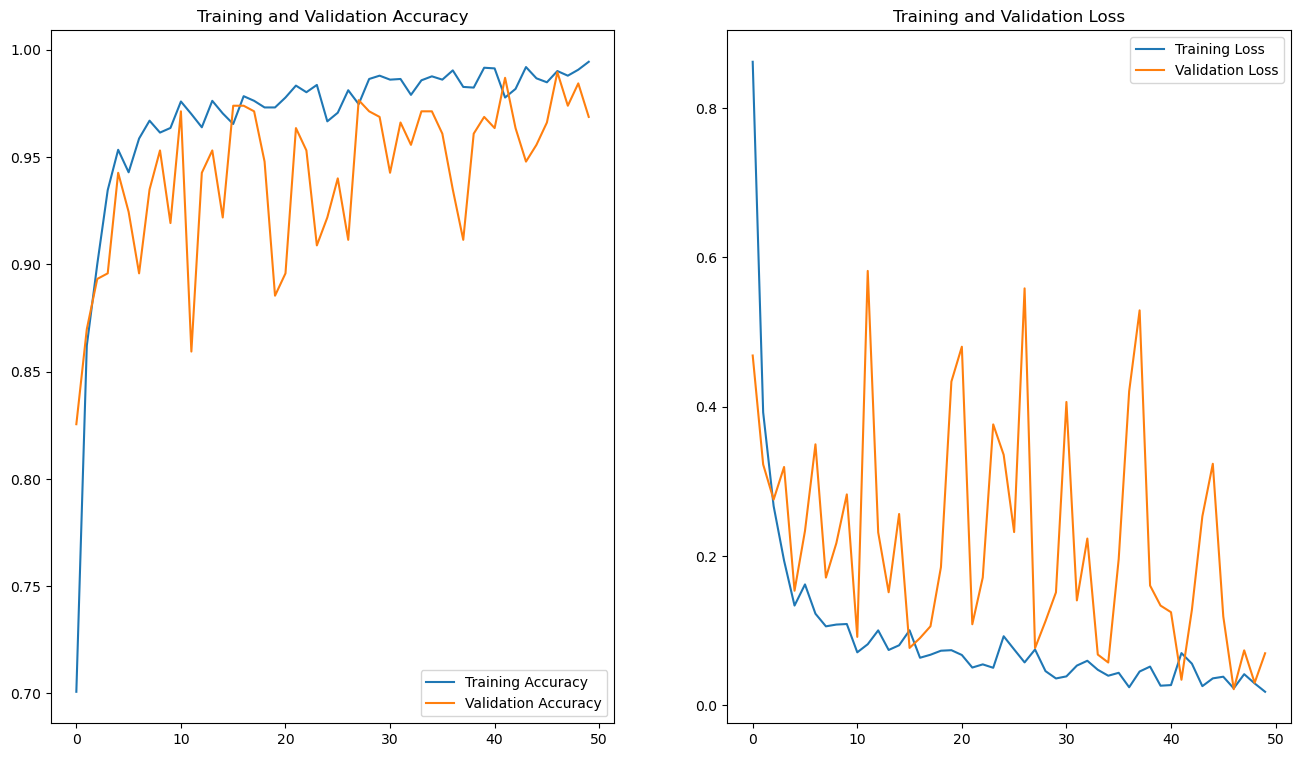

In [33]:
# Visualize training and validation accuracy
plt.figure(figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Visualize training and validation loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

Make Prediction on a sample image

actual label: Tomato_healthy
predicted label: Tomato_healthy


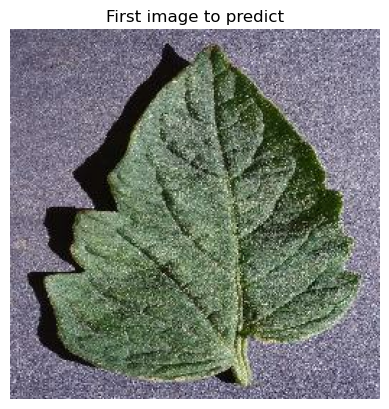

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.title("First image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")
# plt.savefig('first_image.png')

### Make function for Model Inference

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

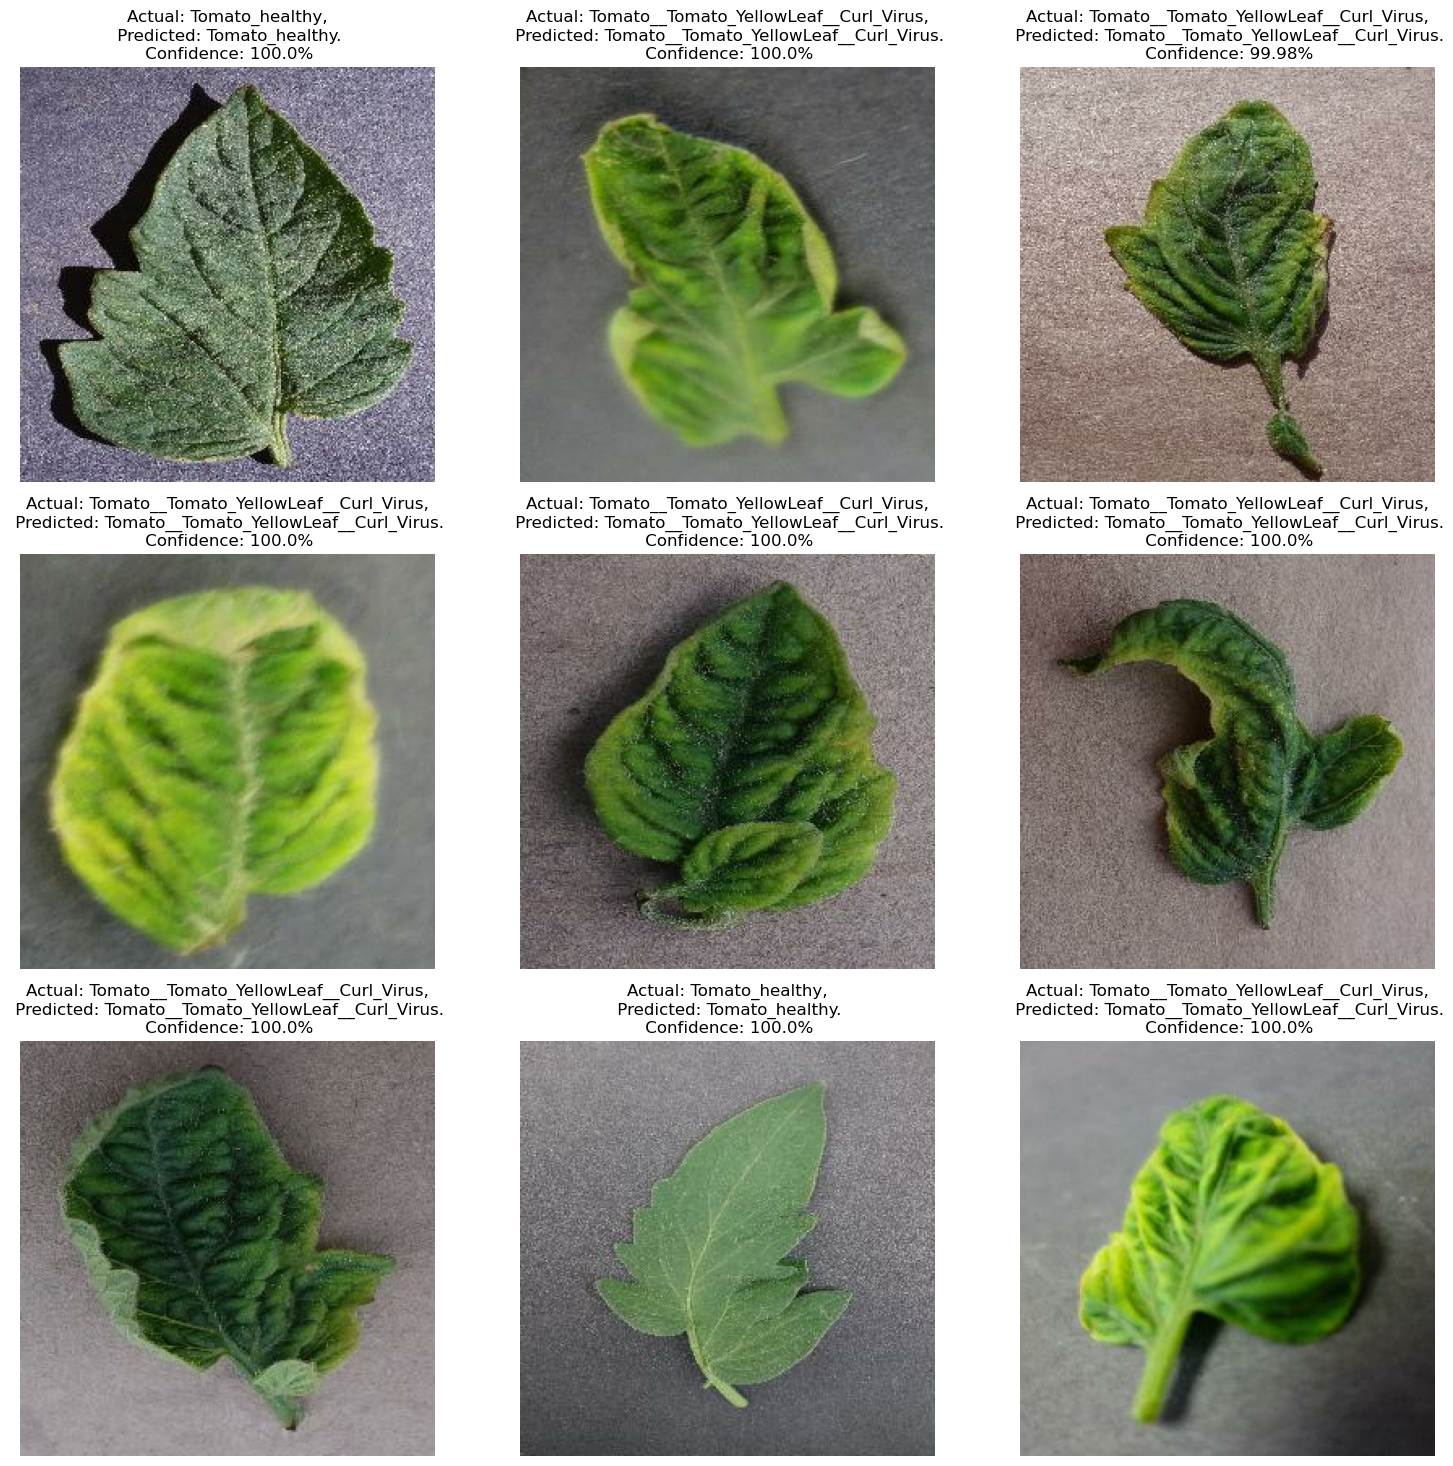

In [36]:
# Visualize predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.tight_layout()
        plt.axis("off")
plt.savefig("predictions_visualize.png")

Saving the Model

In [37]:
# Save model
# model_version = 1
# model.save(f"../saved_models/{model_version}")

import os
# to save the latest model by adding 1 to the number
model_version = max(int(i) for i in os.listdir("../saved_models") + [0]) + 1 
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/12\assets


## How to Visualize learned feature maps

- In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

In [38]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 64)
conv2d_2 (3, 3, 64, 64)
conv2d_3 (3, 3, 64, 64)
conv2d_4 (3, 3, 64, 64)
conv2d_5 (3, 3, 64, 64)


In [39]:
import warnings
warnings.filterwarnings('ignore')
blocks = []  # to store the index of the filters will be used later
for idx, layer in enumerate(model.layers):
    # print(f"Layer {idx} name: {layer.name}")
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    blocks.append(idx)
    print(f"Index: {idx}, Layer Name: {layer.name}, Filter Shape: {filters.shape}")

Index: 2, Layer Name: conv2d, Filter Shape: (3, 3, 3, 32)
Index: 4, Layer Name: conv2d_1, Filter Shape: (3, 3, 32, 64)
Index: 6, Layer Name: conv2d_2, Filter Shape: (3, 3, 64, 64)
Index: 8, Layer Name: conv2d_3, Filter Shape: (3, 3, 64, 64)
Index: 10, Layer Name: conv2d_4, Filter Shape: (3, 3, 64, 64)
Index: 12, Layer Name: conv2d_5, Filter Shape: (3, 3, 64, 64)


In [40]:
# retrieve weights for the first conv layer
filters , bias = model.layers[2].get_weights()

In [41]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

## Visualize the filters

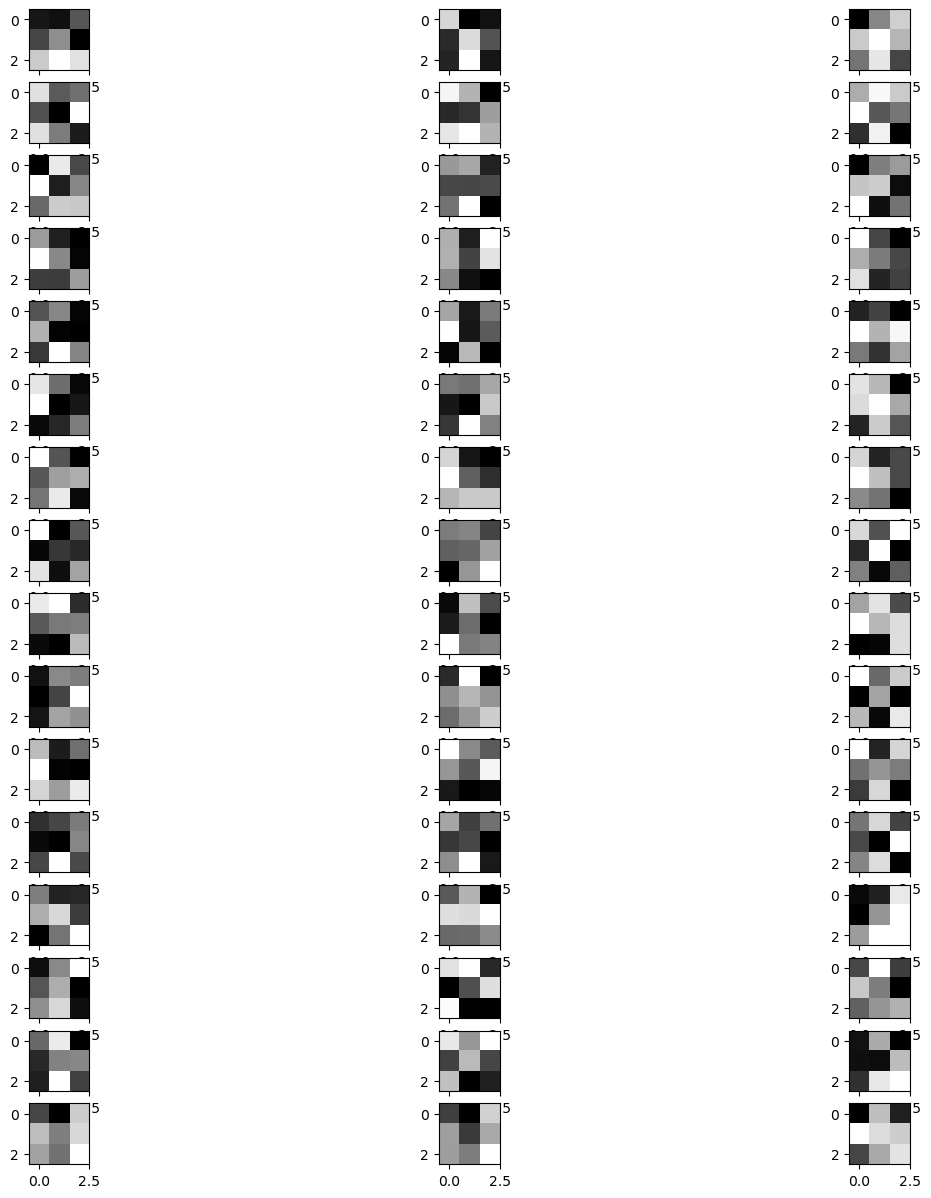

In [42]:
# We will be visualising 6 filters out of 32 filters from 1st conv layer
n_filters = 16
ix=1
fig = plt.figure(figsize=(15,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
# plot the filters
plt.show()

## Visualize the Feature Maps

In [43]:
# shape of the feature maps output by each of the convolution layers 
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

2 conv2d (None, 256, 256, 32)
4 conv2d_1 (None, 128, 128, 64)
6 conv2d_2 (None, 64, 64, 64)
8 conv2d_3 (None, 32, 32, 64)
10 conv2d_4 (None, 16, 16, 64)
12 conv2d_5 (None, 8, 8, 64)


In [44]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tensorflow.keras.models import Model
model_1 = Model(inputs=model.inputs , outputs=model.layers[2].output)

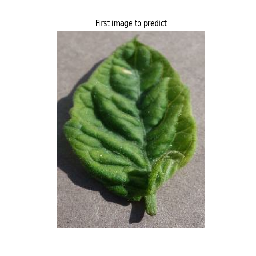

In [45]:
# we will check for a sample image which we saved earlier
# Load the image
image = load_img("first_image.png" , target_size=(256,256))
image

In [46]:
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

In [47]:
# preprocess the image
image = preprocess_input(image)

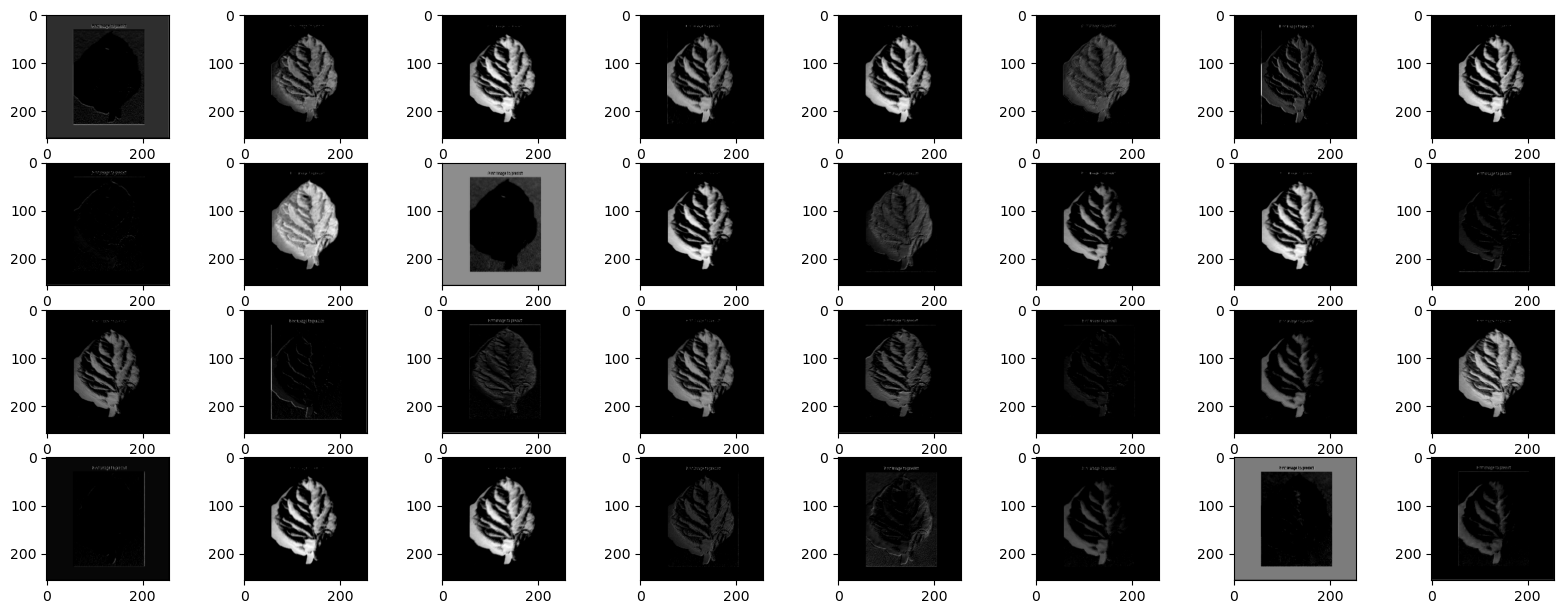

In [48]:
# calculating features_map
features = model_1.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

In [49]:
# Now we will visualise features of other convolutional layers.

model_2 = model
blocks = blocks # saved index from earlier
blocks


[2, 4, 6, 8, 10, 12]

In [50]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [51]:

outputs = [model_2.layers[i].output for i in blocks]
model_2 = Model( inputs= model_2.inputs, outputs = outputs)


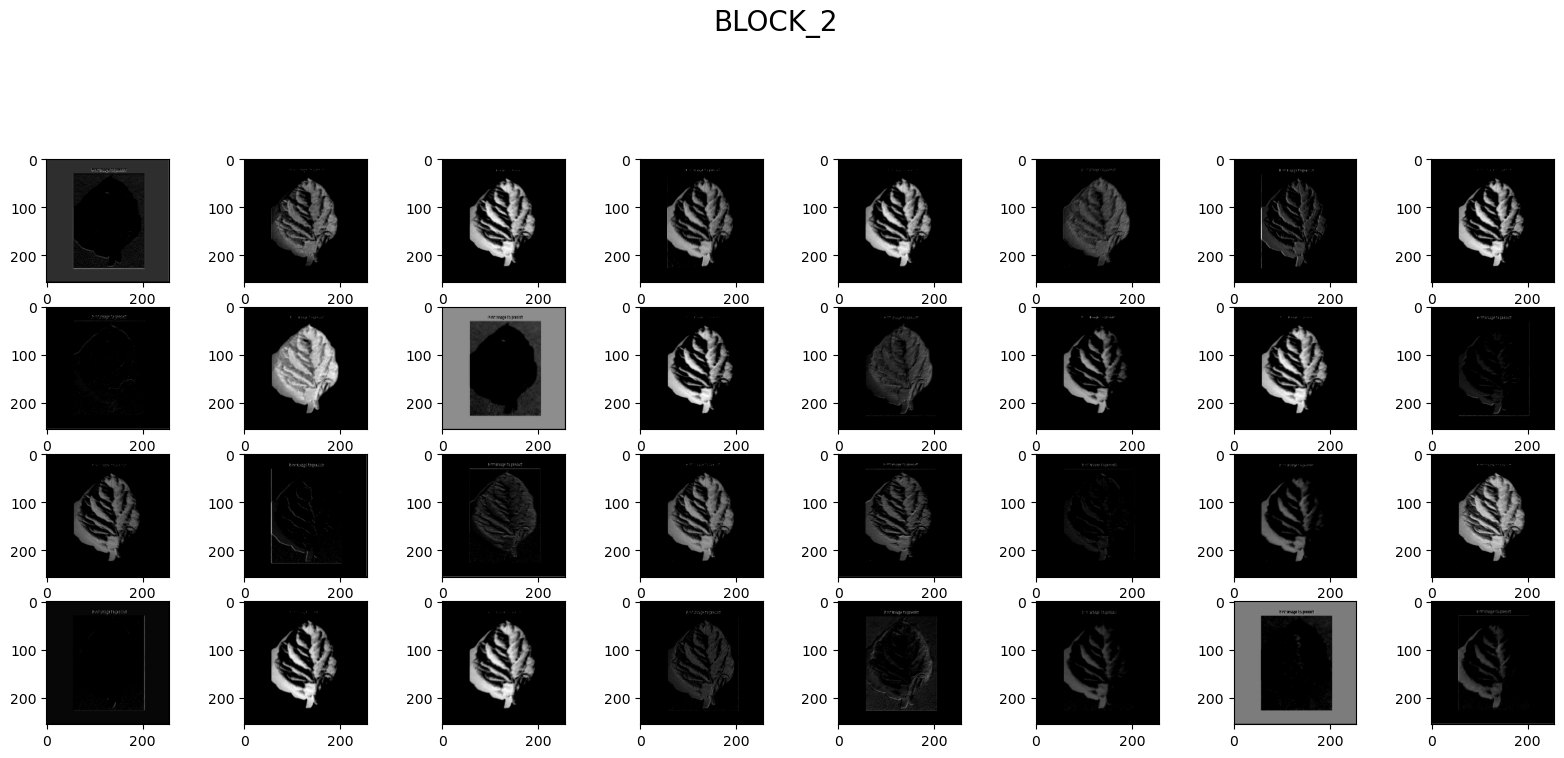

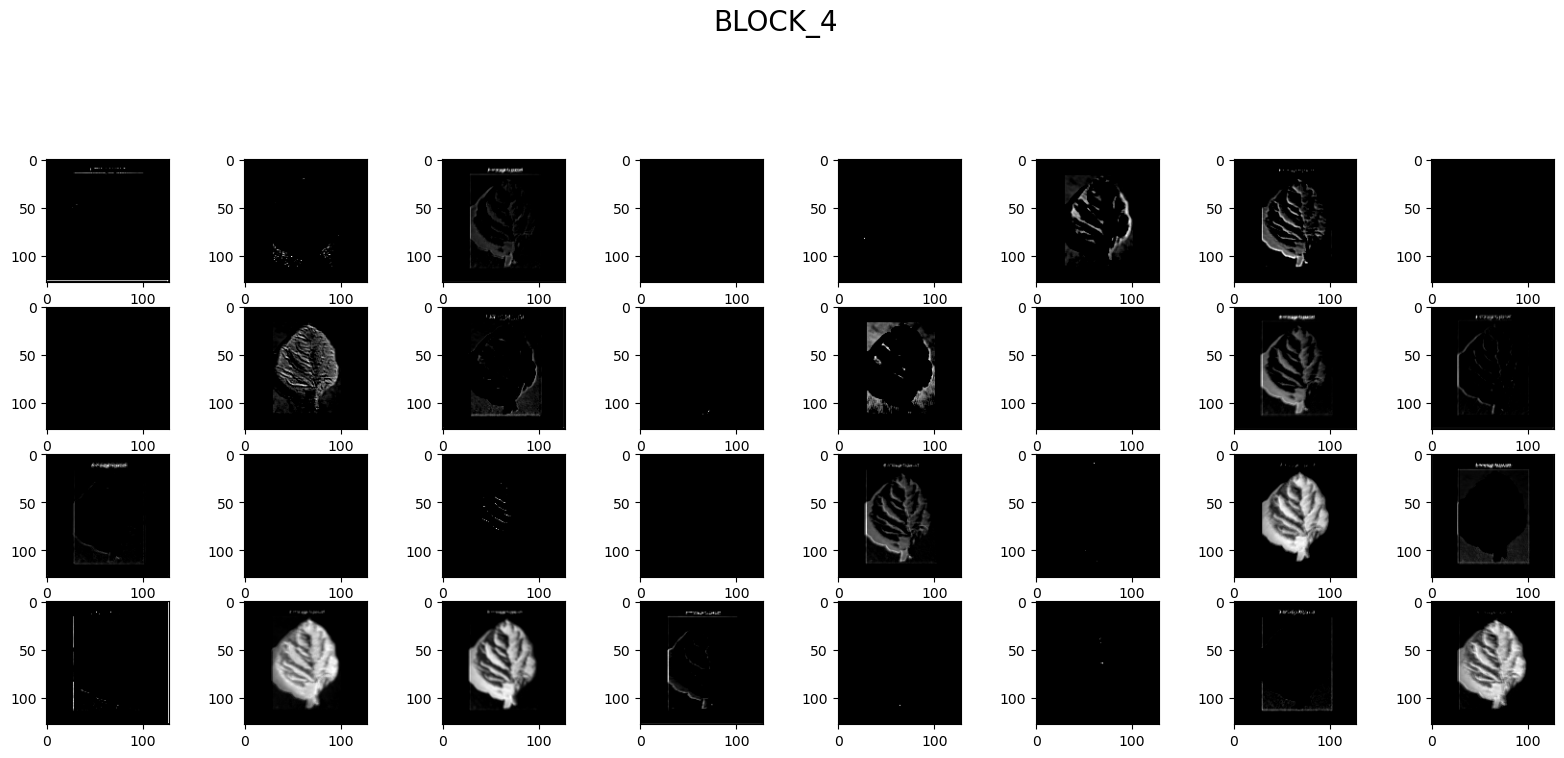

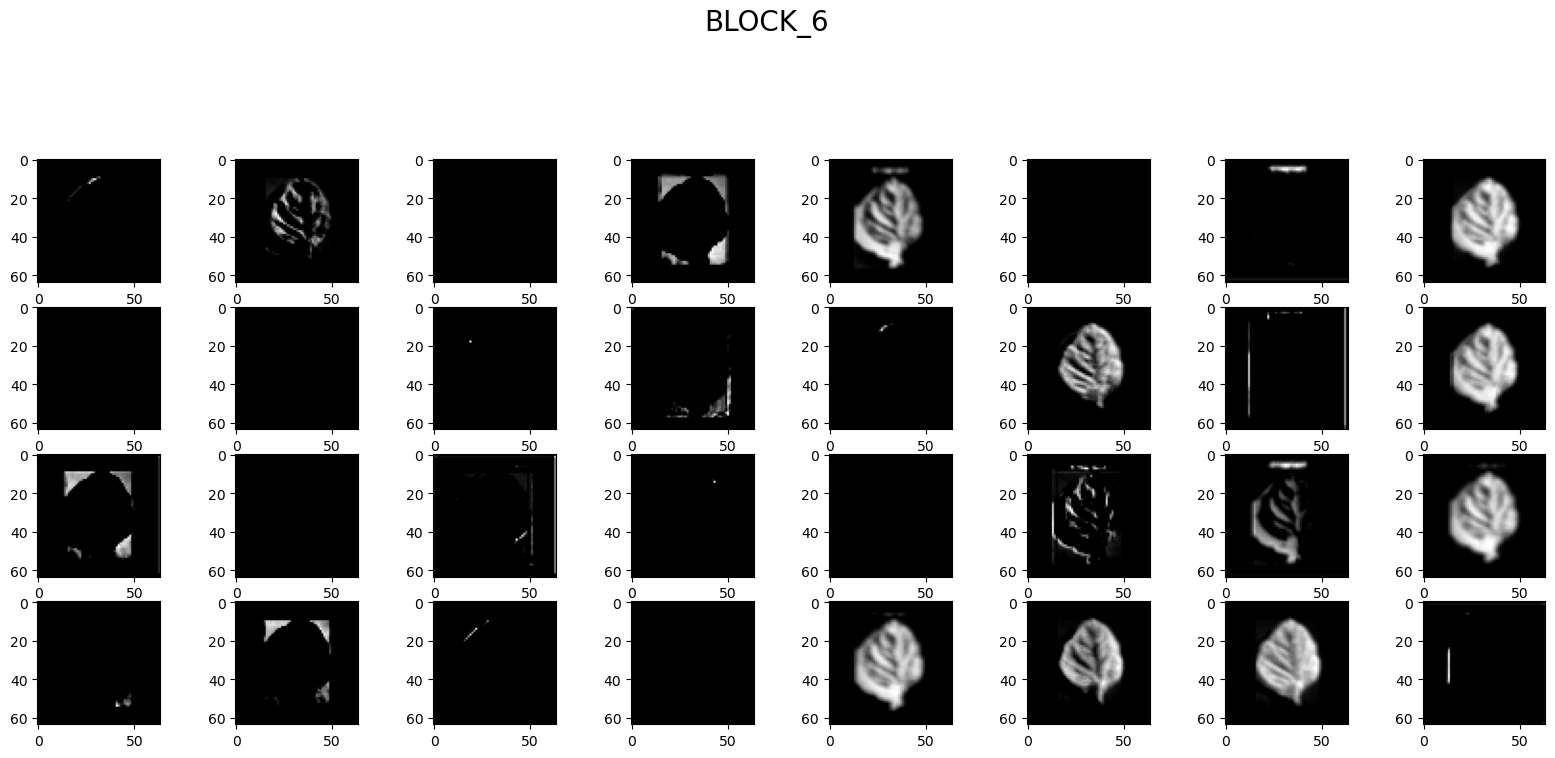

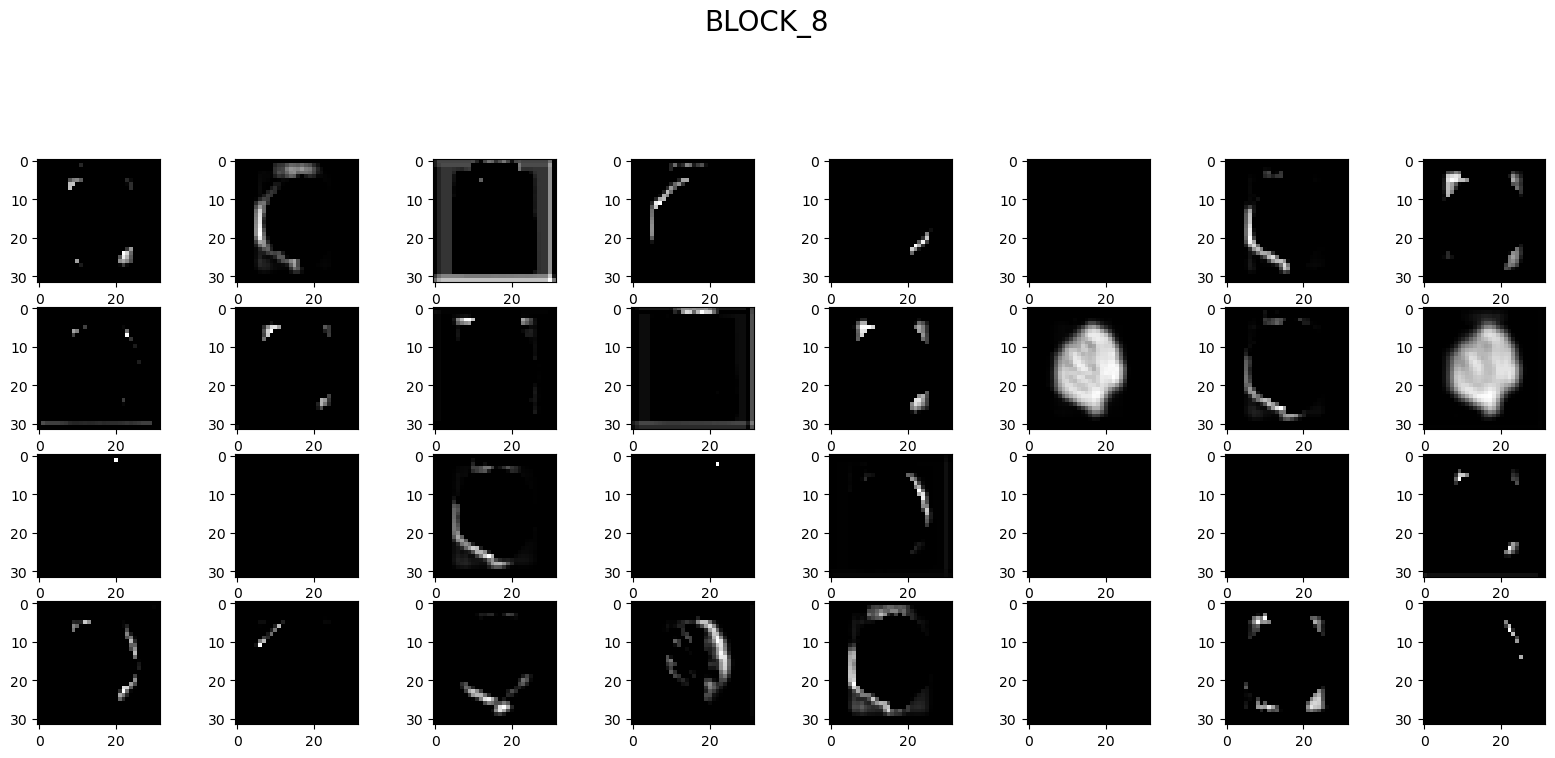

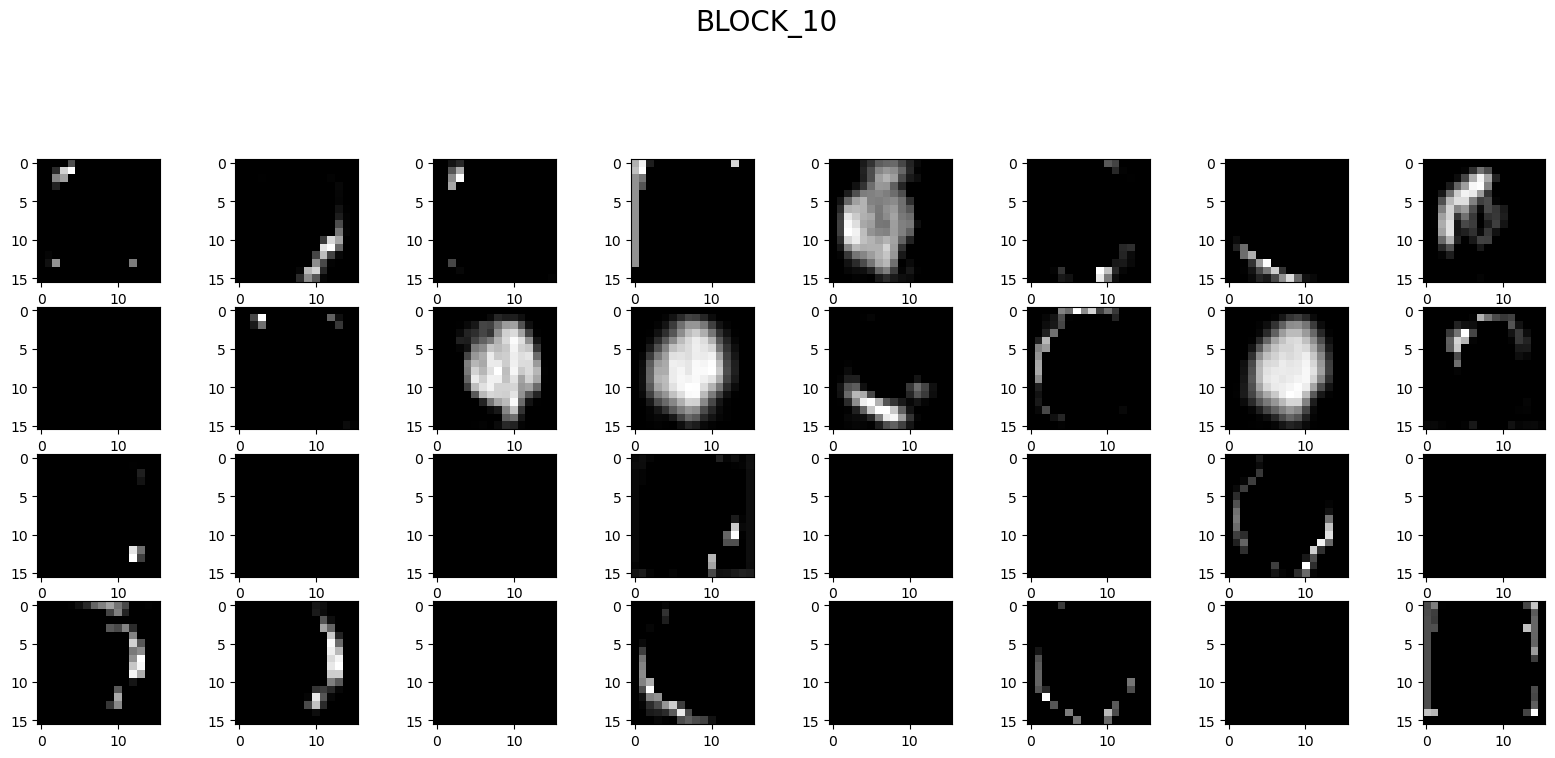

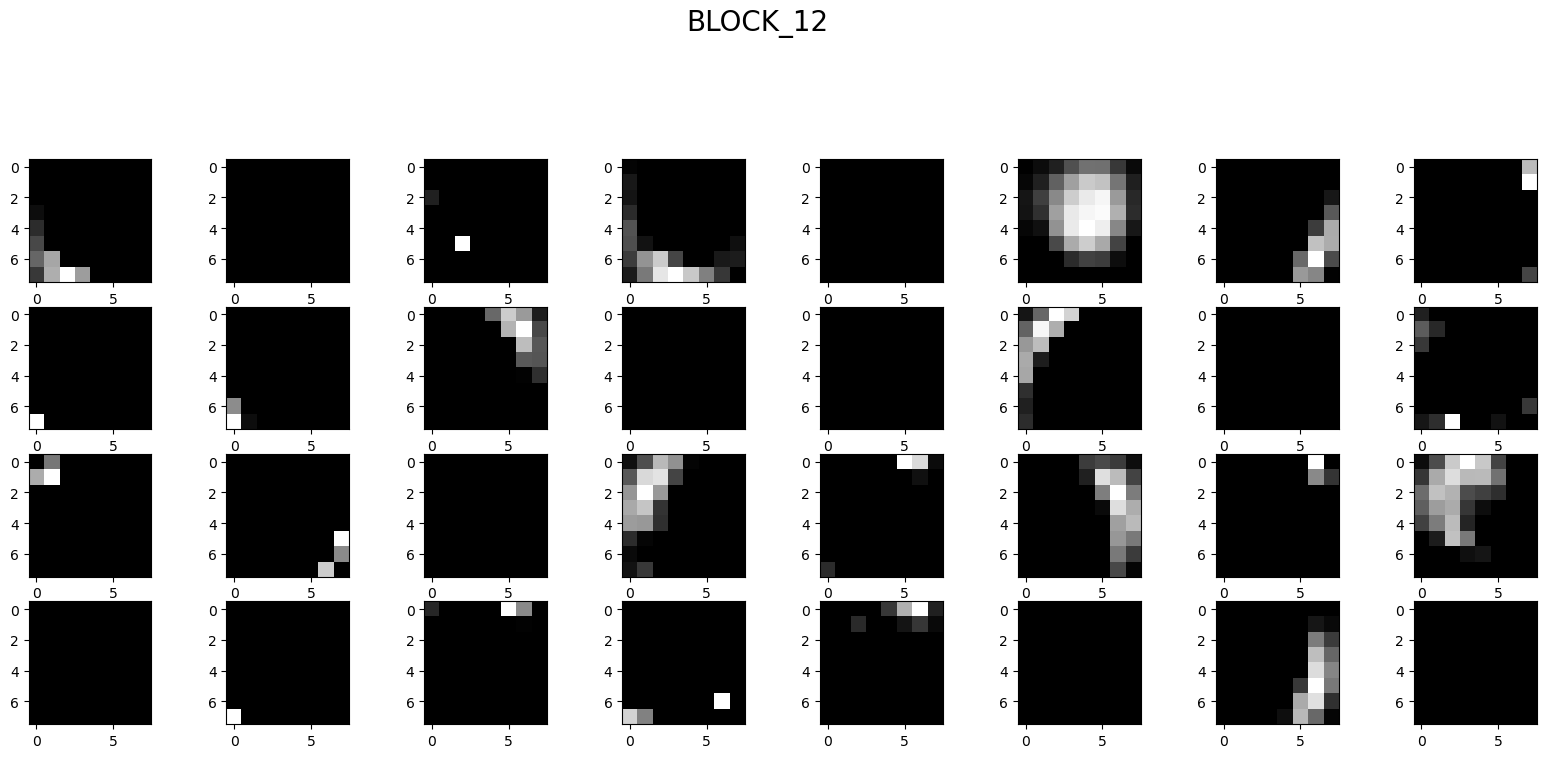

In [52]:
feature_map = model_2.predict(image)

for i,fmap in zip(blocks,feature_map):
    fig = plt.figure(figsize=(20,15))
    # https://stackoverflow.com/a/12444777
    fig.suptitle(f"BLOCK_{i}", fontsize=20)
    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')

plt.show()